# 09_Benchmarks

- Silhoutte score
- ARI
- NMI
- LISI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
import os
import simba as si

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

In [8]:
simba_spatial_fn = 'result_simba_spatial/adata_C.h5ad'
simba_spatial_adata_C = sc.read_h5ad(simba_spatial_fn)

In [10]:
simba_spatial_adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'
    uns: 'color', 'pca', 'spatialLIBD_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'softmax'

In [7]:
from sklearn.metrics import silhouette_score

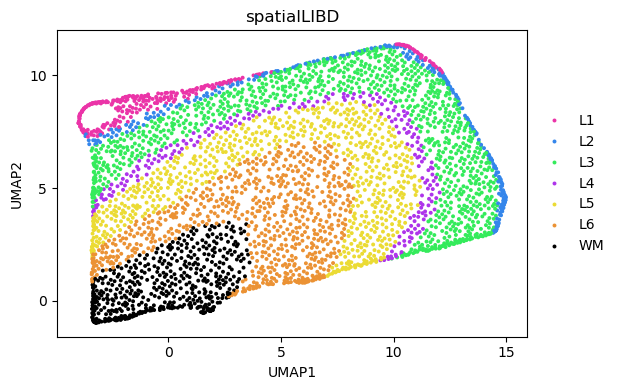

In [14]:
si.pl.umap(
    simba_spatial_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

Euclidean distance in graph embedding space

In [27]:
def get_pairwise_distance(adata):
    diff = adata.X[:, np.newaxis, :] - adata.X[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2) )
    return distances 

In [28]:
simba_spatial_adata_cell_dst = get_pairwise_distance(simba_spatial_adata_C)

In [29]:
simba_spatial_SC = silhouette_score(X=simba_spatial_adata_cell_dst, labels=simba_spatial_adata_C.obs['spatialLIBD'])

In [30]:
SC

0.05002235

## RNA only

In [22]:
simba_rna_fn = 'result_simba_rnaseq_spatialLIBD/adata_C.h5ad'
simba_rna_adata_C = sc.read_h5ad(simba_rna_fn)

In [23]:
simba_rna_adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'
    uns: 'color'
    obsm: 'X_umap'

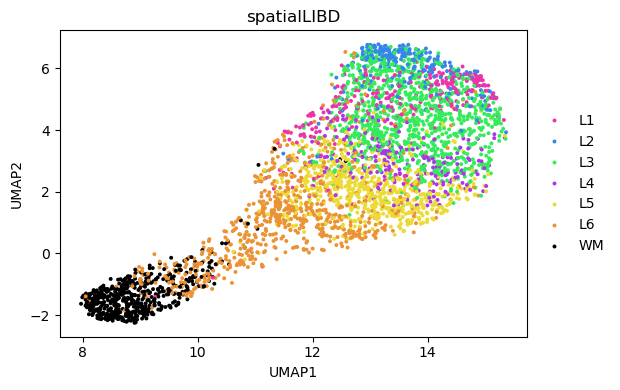

In [24]:
si.pl.umap(
    simba_rna_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [31]:
simba_rna_adata_cell_dst = get_pairwise_distance(simba_rna_adata_C)

In [32]:
simba_rna_SC = silhouette_score(X=simba_rna_adata_cell_dst, labels=simba_rna_adata_C.obs['spatialLIBD'])

In [33]:
simba_rna_SC

-0.016990291